In [26]:
import os
import sys
import json
from time import perf_counter

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorboard as tb
import pandas as pd

In [27]:
sys.path.append(os.path.join(os.getcwd(), "../"))

from models import models
from core.dataset import output_dataset
from core.metrics import TopKThroughputRatio
from core.pruning import prune_model, get_gzipped_model_size, get_gzipped_model_weights_size

## Top K accuracy and throughput ratio

In [3]:
eval_filenames = [filename for filename in os.listdir('../../results/eval/')]
max_k = 20

In [4]:
def top_k_eval(filenames, replace_model_str=''):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    for filename in filenames:
        with open(f'../../results/eval/{filename}') as file:
            results = json.load(file)

        name = filename.replace('.json', '').replace('-', ' ').replace(replace_model_str, '')
        axs[0].plot(np.arange(max_k), results['top-k-accuracy'][:max_k], label=name)
        axs[1].plot(np.arange(max_k), results['top-k-throughput-ratio'][:max_k], label=name)

    axs[1].legend(title='Models', bbox_to_anchor=(1.05, 1))
    axs[0].set_title('Top K Accuracy')
    axs[1].set_title('Top K Throughput Ratio')
    axs[0].set_xlim(0, 20)
    axs[1].set_xlim(0, 20)
    
    plt.tight_layout()
    return fig, axs

### All

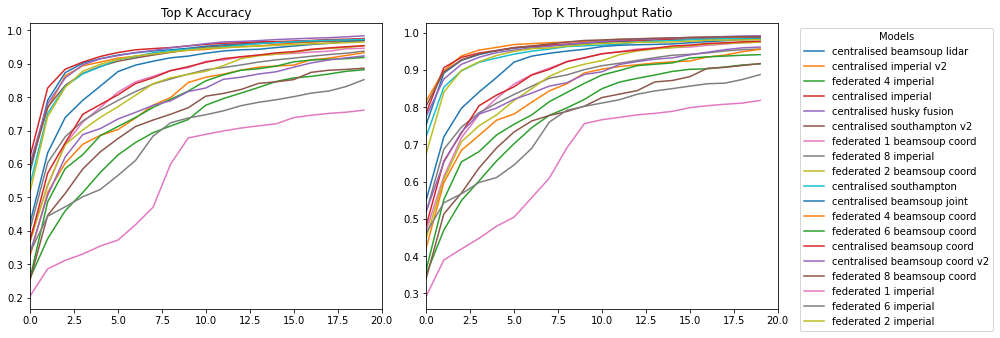

In [5]:
top_k_eval(eval_filenames)
plt.savefig('figs/top-k.png')

### Centralised

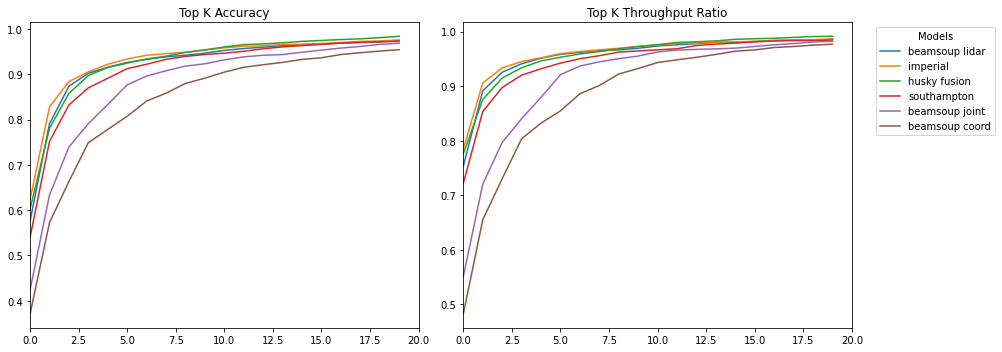

In [6]:
centralised_eval_filenames = [filename for filename in eval_filenames 
                              if 'centralised' in filename and 'v2' not in filename]
top_k_eval(centralised_eval_filenames, 'centralised ')
plt.savefig('figs/centralised-top-k.png')

### Federated

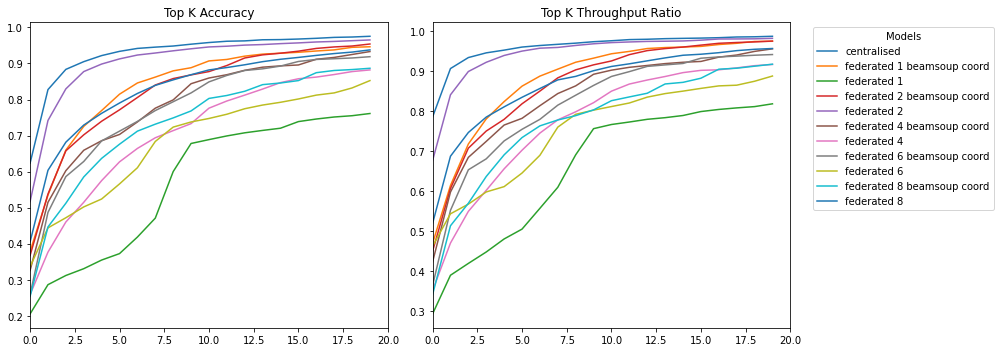

In [7]:
federated_eval_filenames = sorted([filename for filename in eval_filenames 
                                   if 'federated' in filename or filename == 'centralised-imperial.json'])
top_k_eval(federated_eval_filenames, ' imperial')
plt.savefig('figs/federated-top-k.png')

## True output

62/62 [==============================] - 2s 23ms/step - loss: 1.7709 - top-1-accuracy: 0.6235 - top-10-accuracy: 0.9536 - top-1-throughput: 0.7742 - top-10-throughput: 0.9713


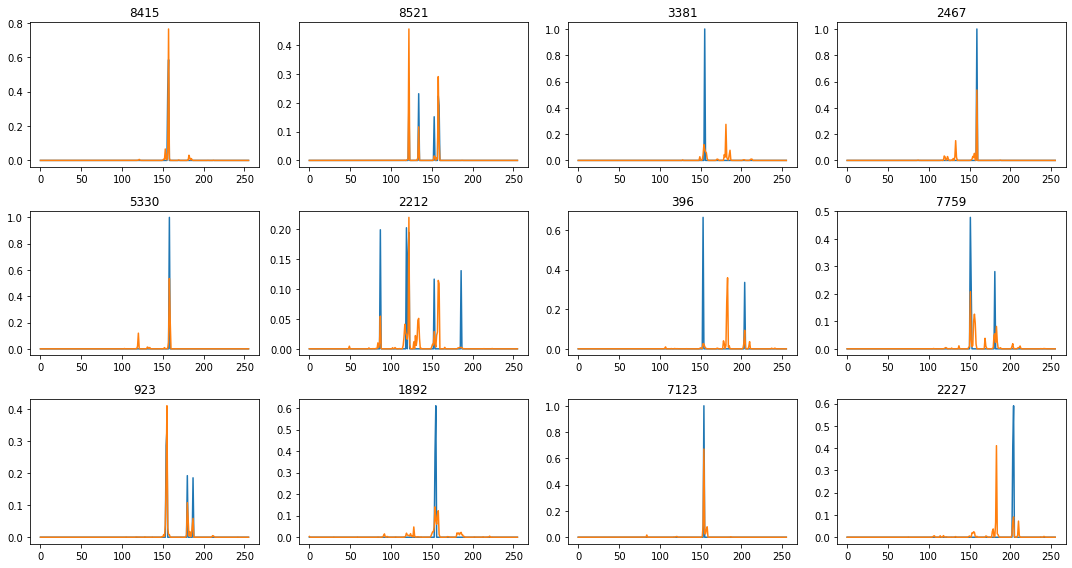

In [8]:
model_fn, dataset_fn = models['imperial']
model = tf.keras.models.load_model('../../results/models/centralised-imperial/model', 
                                   custom_objects={'TopKThroughputRatio': TopKThroughputRatio})

training_input, validation_input = dataset_fn('../../data')
training_output, validation_output = output_dataset('../../data')

fig, axs = plt.subplots(3, 4, figsize=(15, 8))
for ax in axs.flatten():
    pos = np.random.randint(0, len(training_input))
    ax.plot(np.arange(256), training_output[pos], label='True')
    ax.plot(np.arange(256), model(np.array([training_input[pos]]))[0], label='Predicted')
    ax.set_title(pos)
    
plt.tight_layout()
plt.savefig('figs/true-output.png')

evaluation = model.evaluate(validation_input, validation_output)

### True output v2

62/62 [==============================] - 2s 21ms/step - loss: 4.5011 - top-1-accuracy: 0.5969 - top-10-accuracy: 0.9403 - top-1-throughput: 0.7975 - top-10-throughput: 0.9726


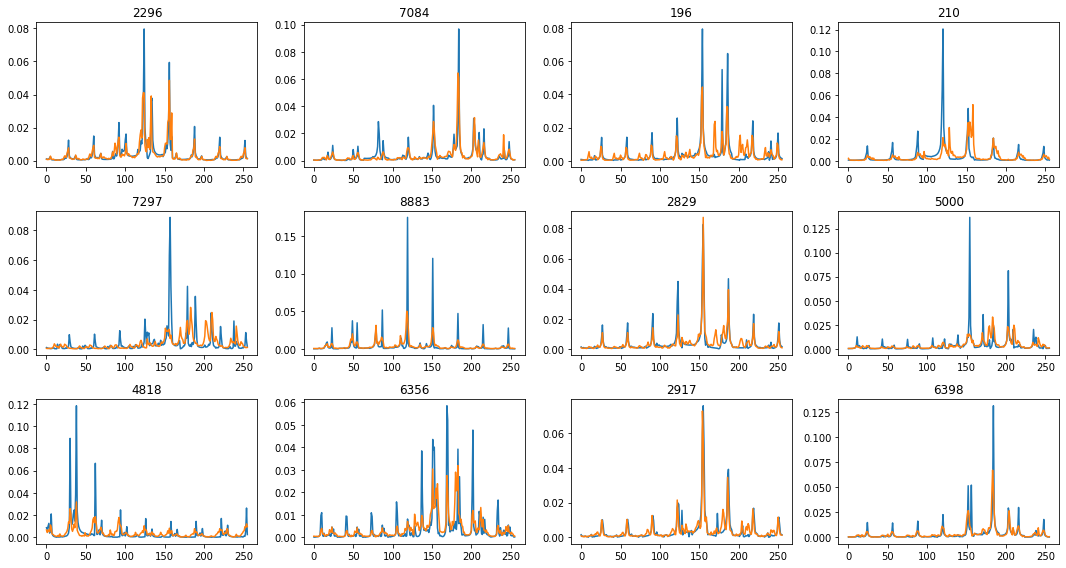

In [9]:
model_fn, dataset_fn = models['imperial']
model = tf.keras.models.load_model('../../results/models/centralised-imperial-v2/model', 
                                   custom_objects={'TopKThroughputRatio': TopKThroughputRatio})

training_input, validation_input = dataset_fn('../../data')
training_output, validation_output = output_dataset('../../data', version='v2')

fig, axs = plt.subplots(3, 4, figsize=(15, 8))
for ax in axs.flatten():
    pos = np.random.randint(0, len(training_input))
    ax.set_title(pos)
    ax.plot(np.arange(256), training_output[pos], label='True')
    ax.plot(np.arange(256), model(np.array([training_input[pos]]))[0], label='Predicted')

plt.tight_layout()
plt.savefig('figs/true-output-v2.png')
evaluation = model.evaluate(validation_input, validation_output)

## Training tensorboard

In [10]:
df = pd.read_csv('../../results/tensorboard-logs.csv')

df

,model-name,setting,metric,step,value
0,centralised-beamsoup-coord,train,loss,0,10.247200
1,centralised-beamsoup-coord,train,loss,1,4.783859
2,centralised-beamsoup-coord,train,loss,2,4.294759
3,centralised-beamsoup-coord,train,loss,3,4.006813
4,centralised-beamsoup-coord,train,loss,4,3.802832
...,...,...,...,...,...
15295,centralised-beamsoup-coord-v2,validation,top-10-throughput,25,0.897096
15296,centralised-beamsoup-coord-v2,validation,top-10-throughput,26,0.891942
15297,centralised-beamsoup-coord-v2,validation,top-10-throughput,27,0.885802
15298,centralised-beamsoup-coord-v2,validation,top-10-throughput,28,0.894536


In [11]:
def df_setting_values(model, metric, setting):
    return df[(df['model-name'] == model) & (df['metric'] == metric) & (df['setting'] == setting)]['value'].to_numpy()

def plt_tensorboard_logs(models, metrics, setting):
    fig, axs = plt.subplots(1, len(metrics))
    for ax, metric in zip(axs, metrics):
        ax.set_title(metric)
        for model in models:
            ax.plot(np.arange(30), 
                    df[(df['model-name'] == model) & (df['setting'] == setting) &  (df['metric'] == metric)]['value'].to_numpy(),
                    label=model)
        ax.legend()
    fig.suptitle(setting)
    return fig, axs

### Training vs validation over epochs

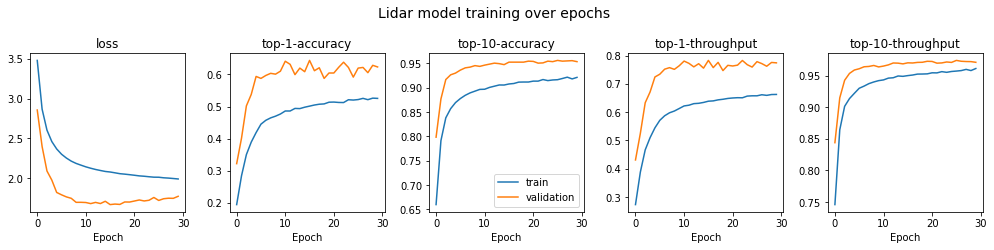

In [12]:
model_name = 'centralised-imperial'

fig, axs = plt.subplots(1, 5, figsize=(14, 3.5))
fig.suptitle('Lidar model training over epochs', fontsize=14)
for ax, metric in zip(axs, pd.unique(df['metric'])):
    ax.set_title(metric)
    ax.plot(np.arange(30), df_setting_values(model_name, metric, 'train'), label='train')
    ax.plot(np.arange(30), df_setting_values(model_name, metric, 'validation'), label='validation')
    ax.set_xlabel('Epoch')
axs[2].legend()
plt.tight_layout()
plt.savefig('figs/centralised-imperial-metrics.png')

### Training and Validation loss, accuracy and throughput over epochs with different models

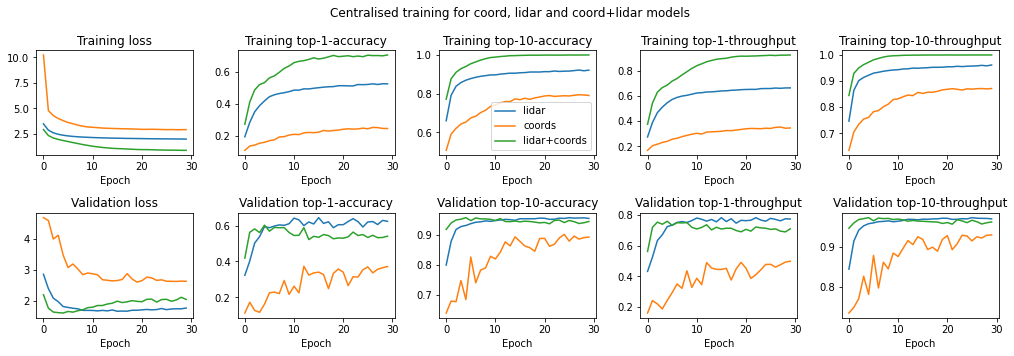

In [13]:
model_names = ['centralised-imperial', 'centralised-beamsoup-coord', 'centralised-southampton']
names = ['lidar', 'coords', 'lidar+coords']

fig, axs = plt.subplots(2, 5, figsize=(14, 5))
fig.suptitle('Centralised training for coord, lidar and coord+lidar models')
for pos, metric in enumerate(pd.unique(df['metric'])):
    axs[0, pos].set_title(f'Training {metric}')
    axs[1, pos].set_title(f'Validation {metric}')
    for name, model_name in zip(names, model_names):
        axs[0, pos].plot(np.arange(30), df_setting_values(model_name, metric, 'train'), label=name)
        axs[1, pos].plot(np.arange(30), df_setting_values(model_name, metric, 'validation'), label=name)
[ax.set_xlabel('Epoch') for ax in axs.flatten()]
axs[0, 2].legend()
plt.tight_layout()
plt.savefig('figs/centralised-training-val-metrics.png')

### V2 Training and Validation loss, accuracy and throughput over epochs

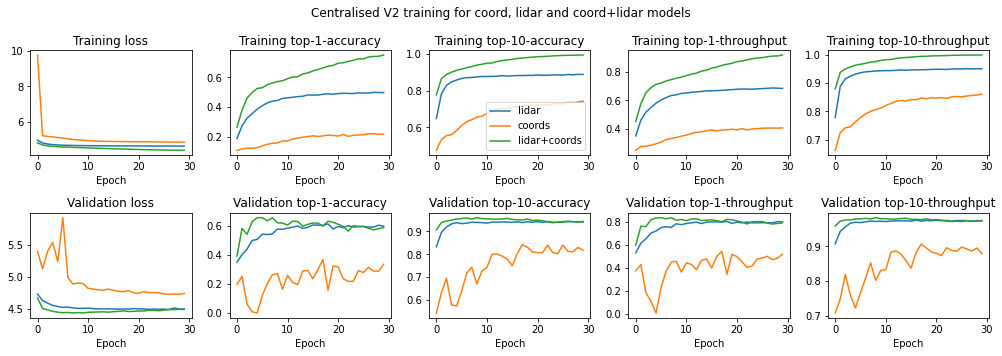

In [14]:
model_names = ['centralised-imperial-v2', 'centralised-beamsoup-coord-v2', 'centralised-southampton-v2']
names = ['lidar', 'coords', 'lidar+coords']

fig, axs = plt.subplots(2, 5, figsize=(14, 5))
fig.suptitle('Centralised V2 training for coord, lidar and coord+lidar models')
for pos, metric in enumerate(pd.unique(df['metric'])):
    axs[0, pos].set_title(f'Training {metric}')
    axs[1, pos].set_title(f'Validation {metric}')
    for name, model_name in zip(names, model_names):
        axs[0, pos].plot(np.arange(30), df_setting_values(model_name, metric, 'train'), label=name)
        axs[1, pos].plot(np.arange(30), df_setting_values(model_name, metric, 'validation'), label=name)
[ax.set_xlabel('Epoch') for ax in axs.flatten()]
axs[0, 2].legend()
plt.tight_layout()
plt.savefig('figs/centralised-v2-training-val-metrics.png')

### Federated learning of global models with different numbers of vehicles

In [22]:
with open('../../results/eval/federated-1-imperial.json') as file:
    data = json.load(file)
data['history']

[{'vehicle 0': {'loss': [[3]],
   'top-1-accuracy': [[0]],
   'top-10-accuracy': [[0]],
   'top-1-throughput': [[0]],
   'top-10-throughput': [[0]],
   'val_loss': [[2]],
   'val_top-1-accuracy': [[0]],
   'val_top-10-accuracy': [[0]],
   'val_top-1-throughput': [[0]],
   'val_top-10-throughput': [[0]]},
  'global': {'loss': 3.510664224624634,
   'top-1-accuracy': 0.28341835737228394,
   'top-10-accuracy': 0.7943877577781677,
   'top-1-throughput': 0.38692107796669006,
   'top-10-throughput': 0.838596761226654}},
 {'vehicle 0': {'loss': [[2]],
   'top-1-accuracy': [[0]],
   'top-10-accuracy': [[0]],
   'top-1-throughput': [[0]],
   'top-10-throughput': [[0]],
   'val_loss': [[2]],
   'val_top-1-accuracy': [[0]],
   'val_top-10-accuracy': [[0]],
   'val_top-1-throughput': [[0]],
   'val_top-10-throughput': [[0]]},
  'global': {'loss': 3.425607919692993,
   'top-1-accuracy': 0.18367347121238708,
   'top-10-accuracy': 0.7454081773757935,
   'top-1-throughput': 0.26131415367126465,
   'top

ValueError: x and y must have same first dimension, but have shapes (30,) and (0,)

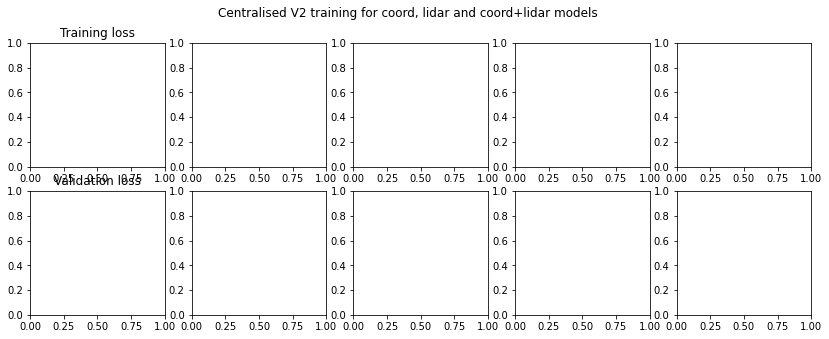

In [15]:
model_names = [f'federated-imperial-{vehicles}-vehicle-global' for vehicles in (2, 4, 6, 8)]
names = [f'{vehicles} vehicles' for vehicles in (2, 4, 6, 8)]

fig, axs = plt.subplots(2, 5, figsize=(14, 5))
fig.suptitle('Centralised V2 training for coord, lidar and coord+lidar models')
for pos, metric in enumerate(pd.unique(df['metric'])):
    axs[0, pos].set_title(f'Training {metric}')
    axs[1, pos].set_title(f'Validation {metric}')
    for name, model_name in zip(names, model_names):
        axs[0, pos].plot(np.arange(30), df_setting_values(model_name, metric, 'train'), label=name)
        axs[1, pos].plot(np.arange(30), df_setting_values(model_name, metric, 'validation'), label=name)
[ax.set_xlabel('Epoch') for ax in axs.flatten()]
axs[0, 2].legend()
plt.tight_layout()
plt.savefig('figs/federated-vehicles-training-val-metrics.png')

### Federated learning of global models with different models

In [ ]:
model_names = ['federated-imperial-8-vehicle-global', 'federated-beamsoup-coord-8-vehicle-global']
names = ['lidar', 'coords', 'lidar+coords']

fig, axs = plt.subplots(2, 5, figsize=(14, 5))
fig.suptitle('Centralised V2 training for coord, lidar and coord+lidar models')
for pos, metric in enumerate(pd.unique(df['metric'])):
    axs[0, pos].set_title(f'Training {metric}')
    axs[1, pos].set_title(f'Validation {metric}')
    for name, model_name in zip(names, model_names):
        axs[0, pos].plot(np.arange(30), df_setting_values(model_name, metric, 'train'), label=name)
        axs[1, pos].plot(np.arange(30), df_setting_values(model_name, metric, 'validation'), label=name)
[ax.set_xlabel('Epoch') for ax in axs.flatten()]
axs[0, 2].legend()
plt.tight_layout()
plt.savefig('figs/federated-models-training-val-metrics.png')

### Federated learning vehicle training and validation loss, accuracy and throughput over epochs

In [ ]:
model_names = [f'federated-imperial-8-vehicle-{vehicle}' for vehicle in range(8)]

fig, axs = plt.subplots(2, 5, figsize=(14, 5))
for pos, metric in enumerate(pd.unique(df['metric'])):
    axs[0, pos].set_title(f'Training {metric}')
    axs[1, pos].set_title(f'Validation {metric}')
    for name, model_name in zip(names, model_names):
        axs[0, pos].plot(np.arange(30), df_setting_values(model_name, metric, 'train'), color='blue')
        axs[1, pos].plot(np.arange(30), df_setting_values(model_name, metric, 'validation'), color='blue')
    axs[0, pos].plot(np.arange(30), df_setting_values('federated-imperial-8-global', metric, 'train'), color='orange')
    axs[1, pos].plot(np.arange(30), df_setting_values('federated-imperial-8-global', metric, 'validation'), color='orange')
[ax.set_xlabel('Epoch') for ax in axs.flatten()]
axs[0, 2].legend()
plt.tight_layout()
plt.savefig('figs/federated-imperial-training-val-metrics.png')

## Pruning

In [28]:
pruning_models = {'imperial': 'centralised-imperial/model',
                  'beamsoup-coord': 'centralised-beamsoup-coord/model',
                  'southampton': 'centralised-southampton/model'}

pruning_sparsity = np.arange(0, 1, 0.05)
models_results = {}
for model_name, model_loc in pruning_models.items():
    print(model_name)
    _, dataset_fn = models[model_name]
    model = tf.keras.models.load_model(f'../../results/models/{model_loc}',
                                       custom_objects={'TopKThroughputRatio': TopKThroughputRatio})
    _, validation_input = dataset_fn('../../data')
    _, validation_output = output_dataset('../../data')

    metrics = model.metrics
    model_results = {name: [] for name in [m.name for m in metrics] + ['model-size', 'weights-size', 'time']}
    for sparsity in pruning_sparsity:
        start_time = perf_counter()
        pruned_model = prune_model(model, sparsity)
        
        model_results['time'] = perf_counter() - start_time
        model_results['model-size'].append(get_gzipped_model_size(pruned_model))
        model_results['weights-size'].append(get_gzipped_model_weights_size(pruned_model))
        
        pruned_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics=metrics)
        pruned_model_results = pruned_model.evaluate(validation_input, validation_output, return_dict=True)
        for metric_name, value in pruned_model_results.items():
            model_results[metric_name].append(value)
    models_results[model_name] = model_results

imperial
Saving pruned model to:  /var/folders/xf/3cnhbc2166j2zrtrl7_hnhtw0000gp/T/tmpimd6dbve.h5
Size of model after compression: 0.09018 Mb
Saving pruned model to:  /var/folders/xf/3cnhbc2166j2zrtrl7_hnhtw0000gp/T/tmp4p1qz72f.h5
Size of model after compression: 0.03091 Mb


TypeError: in user code:

    /Users/marktowers/opt/anaconda3/envs/5G-Beam-Selection/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /Users/marktowers/opt/anaconda3/envs/5G-Beam-Selection/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/marktowers/opt/anaconda3/envs/5G-Beam-Selection/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/marktowers/opt/anaconda3/envs/5G-Beam-Selection/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/marktowers/opt/anaconda3/envs/5G-Beam-Selection/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/marktowers/opt/anaconda3/envs/5G-Beam-Selection/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1217 run_step  **
        outputs = model.test_step(data)
    /Users/marktowers/opt/anaconda3/envs/5G-Beam-Selection/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1188 test_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    /Users/marktowers/opt/anaconda3/envs/5G-Beam-Selection/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:408 update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    /Users/marktowers/opt/anaconda3/envs/5G-Beam-Selection/lib/python3.6/site-packages/tensorflow/python/keras/utils/metrics_utils.py:90 decorated
        update_op = update_state_fn(*args, **kwargs)
    /Users/marktowers/opt/anaconda3/envs/5G-Beam-Selection/lib/python3.6/site-packages/tensorflow/python/keras/metrics.py:177 update_state_fn
        return ag_update_state(*args, **kwargs)

    TypeError: update_state() got multiple values for argument 'sample_weight'
